*This post was entirely written using the IPython notebook. Its content is BSD-licensed. You can see a static view or download this notebook with the help of nbviewer at [20161029_ReplicatingStatisticsForHackers.ipynb](http://nbviewer.ipython.org/urls/raw.github.com/flothesof/posts/master/20161029_ReplicatingStatisticsForHackers.ipynb).*

In this post, we will use the framework for statistical testing presented in ThinkStats to replicate the contents of the talk given at Scipy 2016 by Jake Vanderplas: ["Statistics for Hackers"](https://speakerdeck.com/jakevdp/statistics-for-hackers).

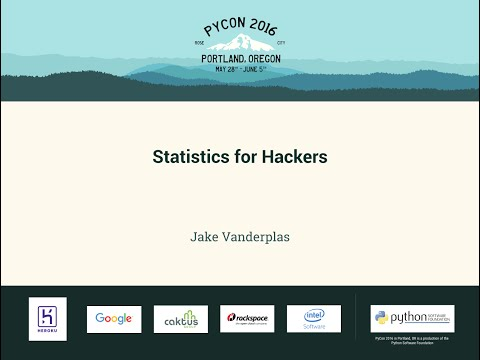

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('Iq9DzN6mvYA')

# What framework? What's ThinkStats?

[Think Stats (Second Edition)](http://greenteapress.com/thinkstats2/) is an effort by [Allen Downey](http://allendowney.blogspot.com) to write a statistics textbook from scratch. It uses Python for practical calculations. One of the ideas that is worth taking in is the explanation that Allen Downey gives of statistical testing and the practical implementation he provides. His idea focuses on simulating statistical test distributions under the null hypothesis instead of the classical analytical approach.

His ideas are, I think, best summed up by the following image from his [blog](http://allendowney.blogspot.com/2016/06/there-is-still-only-one-test.html):

![there is just one test](https://lh4.googleusercontent.com/Bud31guq0w0FvylY57VMR0zHkYqxIpYAfOqgZietyvv1n2ToNEHwHKZWYix8pwct8kDKsZKiwvOWm6PIFEL3gBIQmbakQYHwVT02nn9_H8Fht_zaSBlrRNcqwZa950Vb5nt-5B84)

The framework used in the Think Stats approach mainly consists of this class (taken from the free online version of the book [here](http://greenteapress.com/thinkstats2/html/thinkstats2010.html)):

In [2]:
class HypothesisTest():
    def __init__(self, data):
        self.data = data
        self.MakeModel()
        self.actual = self.TestStatistic(data)

    def PValue(self, iters=1000):
        "Returns p-value of actual data based on simulated data."
        self.test_stats = [self.TestStatistic(self.RunModel()) 
                           for _ in range(iters)]

        count = sum(1 for x in self.test_stats if x >= self.actual)
        self.pval = count / iters
        return self.pval

    def TestStatistic(self, data):
        "Test statistic for the current test."
        raise UnimplementedMethodException()

    def MakeModel(self):
        pass

    def RunModel(self):
        "Returns a simulated data sample."
        raise UnimplementedMethodException()

It mirrors the thinking in the illustration:

- `TestStatistic` is the test statistic to be used for carrying out the statistical test
- `RunModel` builds datasets that are similar to the original dataset but under the $\mathcal{H_0}$ hypothesis
- `PValue` runs many simulations and returns the probability that the statistic is higher than our observed effect in our sampled $\mathcal{H_0}$ hypothetical world

One of the questions that a statistician might ask you when using such a simulation framework is: how do we know that this way of doing thinks is the same as the established metholody in statistical testing? 

To answer this question, we will work on the sample problems described by Jake Vanderplas in his Scipy 2016 talk and compare results. Slides can be found [here](https://speakerdeck.com/jakevdp/statistics-for-hackers).

# First test: coin toss 

For the coin toss problem, the statement is as follows: 

> You toss a coin 30 times and see 22 heads. Is it a fair coin?

Let's take the steps needed to define our statistical testing procedure (as [defined by Allen Downey](http://allendowney.blogspot.fr/2016/06/there-is-still-only-one-test.html)):

- our data is a list of (heads, tails): [22, 8] 
- our model under the $\mathcal{H_0}$ hypothesis is that the coin is fair: the probability of it landing heads or tails is 0.5
- the test statistic is the count of the number of heads in the 30 tosses

Let's implement this!

In [3]:
import random

class CoinTossTest(HypothesisTest):
    """Class for testing if a coin is fair.
    Assumes data will be given as a list like: [number_of_heads, number_of_tails]."""
    
    def TestStatistic(self, data):
        "Counts the number of heads in the data."
        return data[0]

    def RunModel(self):
        "Returns data generated under the H0 hypothesis (the coin is fair)."
        n = sum(self.data)
        tosses = [0, 0]
        for _ in range(n):
            if random.random() > 0.5:
                tosses[0] += 1
            else:
                tosses[1] += 1
        return tosses        

Let's test our test!

In [4]:
coin_test = CoinTossTest([22, 8])

We can compute the test statistic with our real data: it should return 22.

In [5]:
coin_test.actual

22

Also, we can generate a new random sample of 30 coin tosses under the null hypothesis:

In [6]:
coin_test.RunModel()

[13, 17]

Finally, let's sample the distribution of our test statistic and compute the p-value for our particular data:

In [7]:
coin_test.PValue()

0.01

We see our p-value is low. But it is not, given that we simulated only 1000 experiments, the exact p-value, which should be 0.008. Let's compare the obtained distribution and the exact distribution of the test statistic under the null hypothesis.

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')

In [9]:
def plot_simulated_distribution(test, title, bins=30, range=None):
    "Plots the simulated test statistic distribution."
    plt.hist(test.test_stats, bins=bins, range=range, 
             cumulative=False, normed=True,
            label='simulated test stat\ndistribution')
    ylim = plt.ylim()
    plt.vlines(test.actual, *ylim, label='actual test stat\n(p={:.3f})'.format(test.pval))
    plt.legend(loc='upper left')
    plt.xlabel('test statistic value')
    plt.title(title)

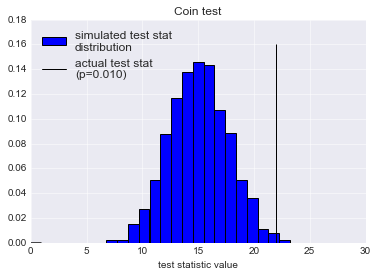

In [10]:
plot_simulated_distribution(coin_test, "Coin test", range=(0, 30), bins=31)

Let's also plot the analytical distribution:

In [11]:
from itertools import accumulate

def ncr(n, r):
    """Returns from n choose r possibilities.
    Source: http://stackoverflow.com/questions/4941753/is-there-a-math-ncr-function-in-python"""
    r = min(r, n-r)
    if r == 0: return 1
    numer = list(accumulate(range(n, n-r, -1), int.__mul__))[-1]
    denom = list(accumulate(range(1, r+1), int.__mul__))[-1]
    return numer//denom

def plot_analytical_coin(n=30):
    "Plots analytical distribution under H_0 hypothesis of n coin tosses landing h heads."
    heads = list(range(n+1))
    probs = [ncr(n, h) * 0.5 ** h * 0.5 ** (n - h) for h in heads]
    plt.plot([h + 0.5 for h in heads], probs, drawstyle='steps', 
             label='analytical test stat\ndistribution')

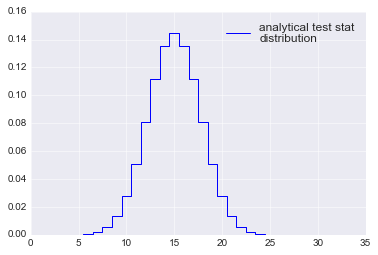

In [12]:
plot_analytical_coin()
plt.legend()

Let's now put the two together:

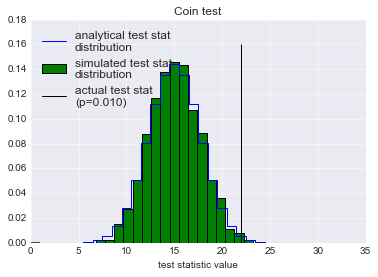

In [13]:
plot_analytical_coin()
plot_simulated_distribution(coin_test, "Coin test", range=(0, 30), bins=31)


The sampled hypothesis is quite close to the exact one. Can we do better?

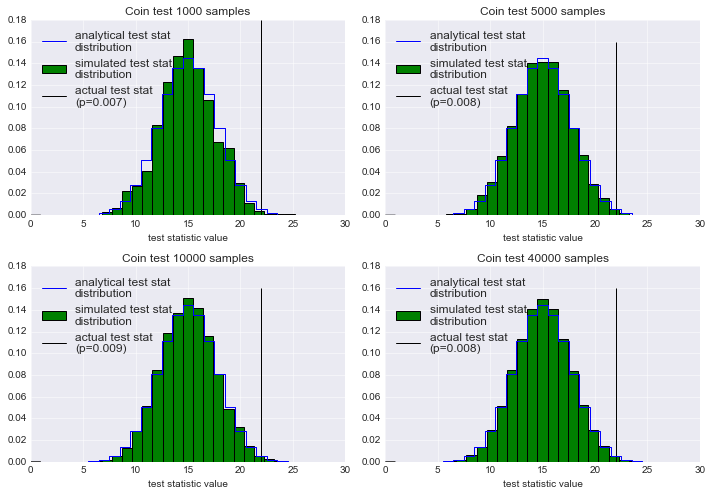

In [14]:
plt.figure(figsize=(10, 7))
for ind, iters in enumerate([1000, 5000, 10000, 40000]):
    plt.subplot(2, 2, ind + 1)
    coin_test = CoinTossTest([22, 8])
    pval = coin_test.PValue(iters=iters)
    plot_analytical_coin()
    plot_simulated_distribution(coin_test, "Coin test {} samples".format(iters), 
                                range=(0, 30), bins=31)
    plt.xlim(0, 30)
plt.tight_layout()

What we see here, is that the sampled distribution, even with as low as 1000 samples, gives an estimate close to the correct answer, which is 0.8 %.

Let's now move on to the next study case.

# Second test: difference in means 

The second problem is as follows:

> A group of start sneeches got the following scores 84, 72, 57, 46, 63, 76, 99, 91 while a group of cross sneeches got these scores 81, 69, 74, 61, 56, 87, 69, 65, 66, 44, 62, 69. There's a difference in means between the two groups (73.5 for the stars, 66.9 for the crosses) but it is significant?

Again, let's describe our test setting:

- our data is a list of scores for the two groups: it's a list of length 2 that contains all the values [[84, 72, 57, 46, 63, 76, 99, 91], [81, 69, 74, 61, 56, 87, 69, 65, 66, 44, 62, 69]]
- our model under the $\mathcal{H_0}$ hypothesis is that there is no difference between the two samples: each group comes from the same distribution of score values
- the test statistic is the same as in Welch's t-test 
$$ 
t = \frac{\bar{X}_1 - \bar{X}_2}{\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}}}
$$


Let's implement the statistical test for this case using the simulation methodology:

In [15]:
import numpy as np

In [16]:
class MeanTest(HypothesisTest):
    """Test for checking if the difference in means of samples is significant."""
    
    def TestStatistic(self, data):
        "Computes Welch's t-test statistic."
        group1, group2 = data
        n1, n2 = len(group1), len(group2)
        s1, s2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
        m1, m2 = np.mean(group1), np.mean(group2)
        return (m1 - m2) / np.sqrt(s1/n1 + s2/n2)

    def RunModel(self):
        "Shuffles the existing data and splits it into two subgroups."
        group1, group2 = self.data[:]
        pool = group1 + group2
        random.shuffle(pool)
        return pool[:len(group1)], pool[len(group1):]

In [17]:
mean_test = MeanTest([[84, 72, 57, 46, 63, 76, 99, 91], 
                      [81, 69, 74, 61, 56, 87, 69, 65, 66, 44, 62, 69]])

Let's check that we implemented the right test statistic: we expect a value of 0.932 (taken from Jake's slides).

In [18]:
mean_test.actual

0.93161477717115826

Now, let's see if we generate random samples correctly:

In [19]:
mean_test.RunModel()

([81, 69, 62, 61, 69, 74, 87, 69],
 [72, 63, 57, 46, 65, 84, 99, 76, 56, 66, 91, 44])

Finally, let's compute a p-value:

In [20]:
mean_test.PValue()

0.176

What does the sampled test statistic distribution under the $\mathcal{H_0}$ hypothesis look like?

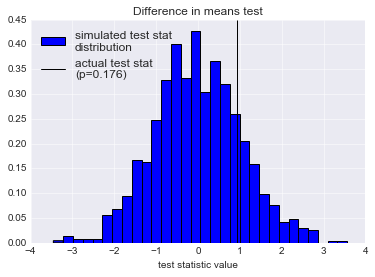

In [21]:
plot_simulated_distribution(mean_test, "Difference in means test")

Again, we will compare the real distribution with the sampled one. Let's write a function that does just that. It turns out that Jake has already put all the information regarding this in his slides. The test statistic has the following probability density:

$$
p(t; \nu) = \frac{\Gamma(\frac{\nu + 1}{2})}{\sqrt{\nu \pi} \Gamma(\frac{\nu}{2}) } \left( 1 + \frac{t^2}{\nu}\right)^{-\frac{\nu + 1}{2}}
$$

In [22]:
from scipy.special import gamma

def plot_analytical_mean(data=[[84, 72, 57, 46, 63, 76, 99, 91], 
                               [81, 69, 74, 61, 56, 87, 69, 65, 66, 44, 62, 69]]):
    "Plots analytical distribution under H_0 hypothesis of the Welch t-stat with given sample sizes."
    group1, group2 = data
    n1, n2 = len(group1), len(group2)
    s1, s2 = np.var(group1, ddof=1), np.var(group2, ddof=1)
    m1, m2 = np.mean(group1), np.mean(group2)
    
    nu = (s1/n1 + s2/n2)**2 / (s1**2 / n1**2 / (n1 - 1) + s2**2 / n2**2 / (n2 - 1))
    t = np.arange(-5, 5, 0.01)
    density = gamma((nu + 1) / 2) / (np.sqrt(nu * np.pi) * gamma(nu / 2)) * (1 + t**2/nu) ** (-(nu + 1)/2)
    
    plt.plot(t, density, drawstyle='steps', 
             label='analytical test stat\ndistribution')

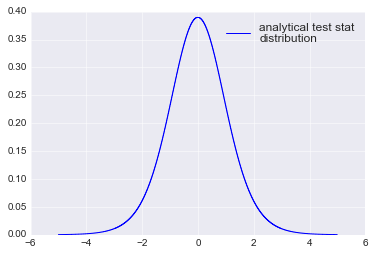

In [23]:
plot_analytical_mean()
plt.legend()

What if we put both plots together, the simulated one and the analytical one?

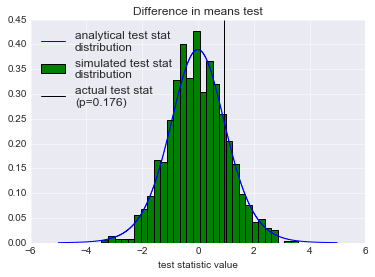

In [24]:
plot_analytical_mean()
plot_simulated_distribution(mean_test, "Difference in means test")


Both distribution look quite similar. Let's check the impact of the number of simulations on the resulting simulated distributions: 

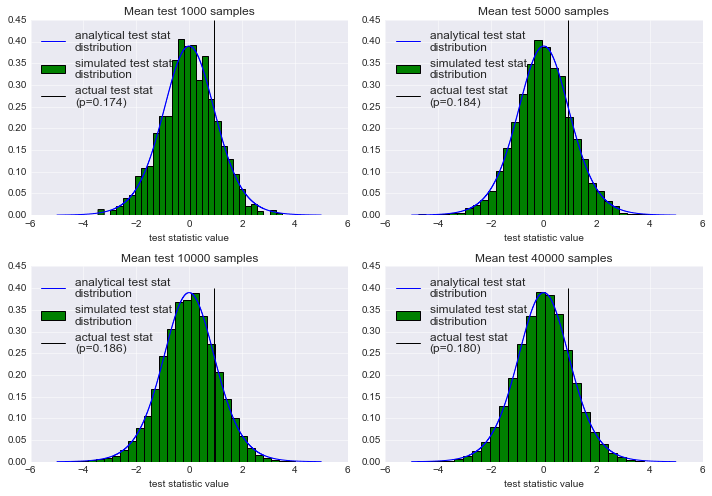

In [25]:
plt.figure(figsize=(10, 7))
for ind, iters in enumerate([1000, 5000, 10000, 40000]):
    plt.subplot(2, 2, ind + 1)
    mean_test = MeanTest([[84, 72, 57, 46, 63, 76, 99, 91], 
                      [81, 69, 74, 61, 56, 87, 69, 65, 66, 44, 62, 69]])
    pval = mean_test.PValue(iters=iters)
    plot_analytical_mean()
    plot_simulated_distribution(mean_test, "Mean test {} samples".format(iters))
plt.tight_layout()

Again, we see the approximation by simulated sampling is quite good compared with the analytical test statistic. And even if in this case a thousand samples is not very close to the exact density, it seems enough for a good idea of the p-value.

An interesting side note here is that Jake VanderPlas does not actually use the test statistic of the analytical test, but seems instead to have reverted to a different, simpler statistic, the difference in means between the two samples. Let's see if we can reproduce his result:

In [26]:
class MeanTest2(MeanTest):
    "Changes the test statistic to a difference in means."
    def TestStatistic(self, data):
        "Computes the difference in means between the two samples."
        group1, group2 = data
        m1, m2 = np.mean(group1), np.mean(group2)
        return m1 - m2

In [27]:
mean_test2 = MeanTest2([[84, 72, 57, 46, 63, 76, 99, 91], 
                      [81, 69, 74, 61, 56, 87, 69, 65, 66, 44, 62, 69]])

The observed effect is:

In [28]:
mean_test2.actual

6.5833333333333286

This value is similar to the one Jake shows on one of his slides. What is the p-value?

In [29]:
mean_test2.PValue()

0.157

Again, we find something close to what Jake has. What does the sampled distribution look like?

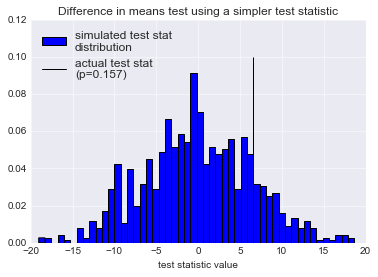

In [30]:
plot_simulated_distribution(mean_test2, "Difference in means test using a simpler test statistic", bins=50)

Let's see what this looks with 10000 iterations (which is what Jake seems to use in his presentation):

(-20, 20)

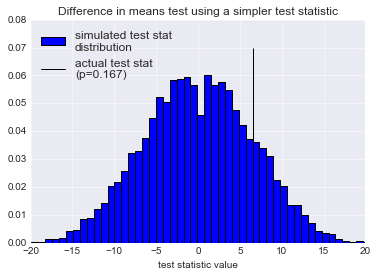

In [31]:
pval = mean_test2.PValue(iters=10000)
plot_simulated_distribution(mean_test2, "Difference in means test using a simpler test statistic", bins=50)
plt.xlim(-20, 20)

Realizing that Jake did not use the "official" test statistic for simulation yields interesting questions:

- are all test statistic equivalent? 
- if not, how do I choose one?
- what if two different test statistics yield two different p-values? which one should I trust?

In my current understanding, I am assuming that not all tests statistics are equal. For instance if I use $t = \sin(\bar{X}_1 - \bar{X}_2)$, I'm not sure that the result will even make sense. You know what let's actually test this.

In [32]:
class MeanTest3(MeanTest):
    "Changes the test statistic to a difference in means."
    def TestStatistic(self, data):
        "Computes the difference in means between the two samples."
        group1, group2 = data
        m1, m2 = np.mean(group1), np.mean(group2)
        return np.sin(m1 - m2)

In [33]:
mean_test3 = MeanTest3([[84, 72, 57, 46, 63, 76, 99, 91], 
                      [81, 69, 74, 61, 56, 87, 69, 65, 66, 44, 62, 69]])
mean_test3.PValue(iters=10000)

0.4139

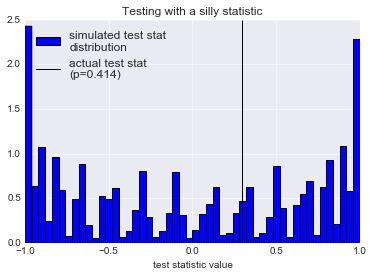

In [34]:
plot_simulated_distribution(mean_test3, "Testing with a silly statistic", bins=50)

Clearly, what we see above is nonsense: it has not the intuitive bell shape we expect from a well defined test statistic. So that would answer the first question. However, using Welch's t-test statistic and the simple difference in means of two samples is not the same thing. So where's the difference? Hopefully, someone can point me to good references about this topic. 

Following this line of inquiry, I'm also wondering about the result shown in Jake's slides: using two different test statistics, he obtains the same p-value. I'm guessing this is just a coincidence. Or is it not?

# Conclusions 

I won't replicate the other parts in Jake Vanderplas' slides (bootstrap resampling and cross-validation) so that this post just focuses on statistics and hypothesis testing.

As we have seen, the simulation framework proposed by ThinkStats is very simple to apply to the two problems found in Jake Vanderplas' Statistics for Hackers presentation. Moreover, we found through comparison of the exact solution and the approximate simulation solution that both approaches yield the same result. While trying to pinpoint the difference in philosophy, we also saw how the simulation approch is very flexible and allows easily changing from one test statistic to another, which is one of the hard points when doing real statistics (think of all the different names for all these tests...).

I think I still have many things to learn with respect to this statistical testing topic and I would be grateful for links regarding the simulation/analytical frontier as well as criteria for choices of test statistic.